In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import pandas as pd
import pathlib
from utils import *
import matplotlib
plt.rcParams.update({'figure.figsize': (4,2.5), 'figure.dpi': 150, 'image.cmap': 'rocket',})

# Process results

In [3]:
data_path = pathlib.Path('/home/users/bjornmik/datasets/sweep_16/')

In [4]:
data_df = pd.read_csv(data_path / 'summary.csv').drop(['Unnamed: 0'],axis=1)

In [5]:
data_df['path'] = data_df.apply(lambda x: pathlib.Path(x.path), axis=1)

In [6]:
errors = compute_errors(data_path, target_weights=['weight<=0'])

  0%|          | 0/80 [00:00<?, ?it/s]

In [7]:
for k, df in errors.items():
    errors[k] = pd.merge(
        df, 
        data_df.loc[:, ['path', 'W_condition', 'W_smin', 'W_smax', 'x_condition',
           'x_smin', 'x_smax', 'cov_condition', 'cov_smin', 'cov_smax']],
        on='path'
    )

In [8]:
for k, df in errors.items():
    errors[k]['sigma'] = df.apply(lambda x: x['glorot_normal']['sigma'], axis=1)

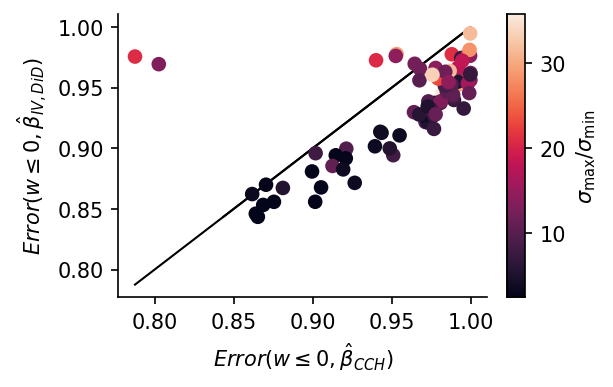

In [79]:
mnorm = matplotlib.colors.LogNorm()
var1 = 'error_naive_cch'
var2 = 'error_beta_iv_did'

for target_weight in errors:
    fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(3.5,2.5), dpi=150)
    xmin, xmax = errors[target_weight].loc[:,[var1, var2]].min(), errors[target_weight].loc[:,[var1, var2]].max()
    sc = ax.scatter(
        errors[target_weight][var1], 
        errors[target_weight][var2], 
        c=errors[target_weight].cov_condition,
#         norm=mnorm
        cmap='rocket'
    )
#     sc = ax.scatter(errors[target_weight][var1], errors[target_weight][var2], c=mnorm(errors[target_weight].cov_condition))
    ax.plot([xmin, xmax], [xmin, xmax], c='k', zorder=0, lw=1)
    lab1 = ",".join([labels[v] for v in var1.split("_")[2:]])
    lab2 = ",".join([labels[v] for v in var2.split("_")[2:]])
    elab = fr'$Error(w < 0, $' if target_weight=='weight<0' else fr'$Error(w = 0, $' if target_weight=='weight==0' else fr'$Error(w \leq 0, $'
    ax.set_xlabel(elab + fr'$\hat{{\beta}}_{{{lab1}}})$')
    ax.set_ylabel(elab + fr'$\hat{{\beta}}_{{{lab2}}})$')
    cbar = plt.colorbar(sc, cax=cax)
#     cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())
#     cbar.ax.set_ylabel(r'$||\mathrm{cov}|| \times ||\mathrm{cov}^{-1}||$')
    cbar.ax.set_ylabel(r'$\sigma_{\mathrm{max}} / \sigma_{\mathrm{min}}$')
    sns.despine()
    savefig(f'sweep_16_error_condition_{target_weight}')

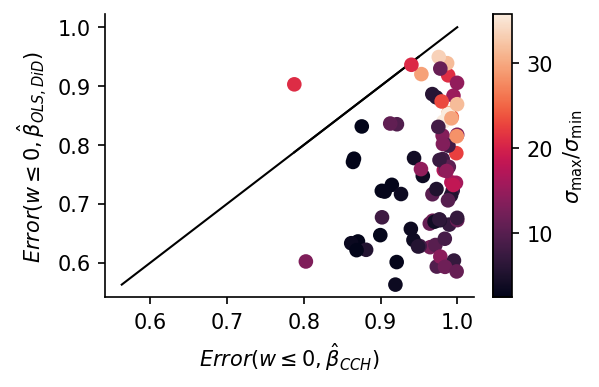

In [80]:
mnorm = matplotlib.colors.LogNorm()
var1 = 'error_naive_cch'
var2 = 'error_beta_ols_did'

for target_weight in errors:
    fig, (ax, cax) = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1,0.05], 'wspace': 0.1}, figsize=(3.5,2.5), dpi=150)
    xmin, xmax = errors[target_weight].loc[:,[var1, var2]].min(), errors[target_weight].loc[:,[var1, var2]].max()
    sc = ax.scatter(
        errors[target_weight][var1], 
        errors[target_weight][var2], 
        c=errors[target_weight].cov_condition,
#         norm=mnorm,
        cmap='rocket'
    )
#     sc = ax.scatter(errors[target_weight][var1], errors[target_weight][var2], c=mnorm(errors[target_weight].cov_condition))
    ax.plot([xmin, xmax], [xmin, xmax], c='k', zorder=0, lw=1)
    lab1 = ",".join([labels[v] for v in var1.split("_")[2:]])
    lab2 = ",".join([labels[v] for v in var2.split("_")[2:]])
    elab = fr'$Error(w < 0, $' if target_weight=='weight<0' else fr'$Error(w = 0, $' if target_weight=='weight==0' else fr'$Error(w \leq 0, $'
    ax.set_xlabel(elab + fr'$\hat{{\beta}}_{{{lab1}}})$')
    ax.set_ylabel(elab + fr'$\hat{{\beta}}_{{{lab2}}})$')
    cbar = plt.colorbar(sc, cax=cax)
#     cbar.ax.set_yticklabels(mnorm.inverse(cbar.ax.get_yticks()).round())
#     cbar.ax.set_ylabel(r'$||\mathrm{cov}|| \times ||\mathrm{cov}^{-1}||$')
    cbar.ax.set_ylabel(r'$\sigma_{\mathrm{max}} / \sigma_{\mathrm{min}}$')
    sns.despine()
    savefig(f'sweep_16_error_condition_brew_{target_weight}')

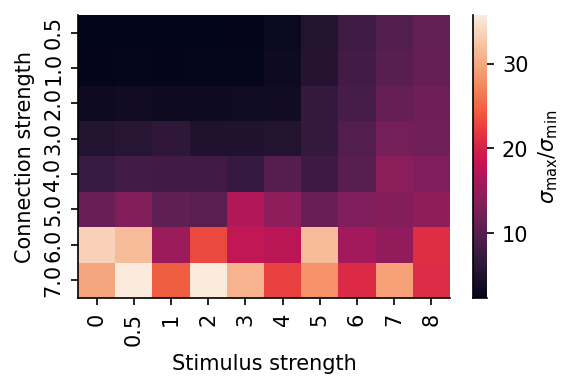

In [82]:
df = errors[list(errors.keys())[0]]
fig, ax = plt.subplots(1,1)
sns.heatmap(
    df.pivot('sigma', 'stim_strength', 'cov_condition'), ax=ax,
    cbar=True, cbar_kws={'label': r'$\sigma_{\mathrm{max}} / \sigma_{\mathrm{min}}$'}
)
ax.set_ylabel('Connection strength')
ax.set_xlabel('Stimulus strength')
ax.set_xticklabels([0,0.5,1,2,3,4,5,6,7,8])
sns.despine()
savefig(f'sweep_16_condition_numbers')

In [14]:
def violin_compare(var1, var2, x='stim_strength', target_weight='weight<0', baselines=None):
    plt.figure()
    key = lambda x: ','.join([labels[l] for l in x.split('_')[2:]])
            
    v1 = errors[target_weight].loc[:, [x, var1]].rename(columns={var1: 'Error'})
    v1[''] = key(var1)
    
    v2 = errors[target_weight].loc[:, [x, var2]].rename(columns={var2: 'Error'})
    v2[''] = key(var2)

    viodf = pd.concat([v1,v2])
    sns.violinplot(
        data=viodf, x=x, y='Error', hue='', split=True, inner="quart", linewidth=1,
        palette={key(var1): colors[key(var1).lower()], key(var2): colors[key(var2).lower()]}, 
        cut=0,
    )

    if baselines is not None:
        for i, (s, df) in enumerate(errors[target_weight].groupby(x)):
            for baseline in baselines:
                plt.plot([i-0.3, i+0.3], [df[baseline].median()]*2, 
                     label=key(baseline) if s==errors[target_weight][x].max() else '', 
                     c=colors[key(baseline).lower()])
    
    sns.despine()
    plt.legend(
        frameon=False,
        bbox_to_anchor=(0,1.0,1,0.2), 
        loc="lower left",
#         mode="expand", 
        borderaxespad=0, ncol=2)
    plt.ylabel('$Error(w < 0)$' if target_weight=='weight<0' else '$Error(w = 0)$')
    plt.xlabel('Stimulus strength')
    plt.gca().set_xticklabels([0.0,0.5,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0]);
    
    savefig(f'sweep_16_violin_stim_strength_{target_weight}')

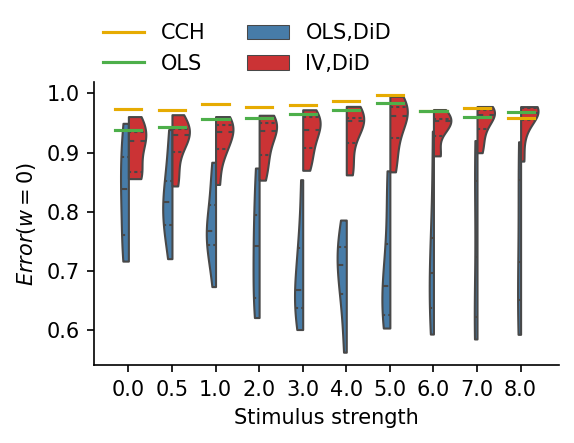

In [15]:
for target_weight in errors:
    violin_compare('error_beta_ols_did', 'error_beta_iv_did', target_weight=target_weight, baselines=['error_naive_cch','error_beta_ols'])
#     violin_compare('error_beta_iv_did', 'error_beta_brew_did', k=k)

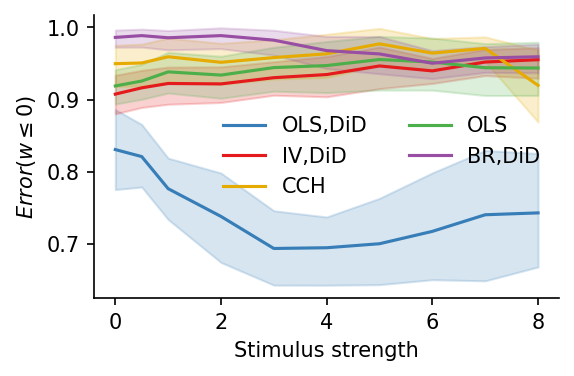

In [72]:
from utils import labels, colors
label = lambda x: ','.join([labels[l] for l in x.split('_')[2:]])
keys = ['error_beta_ols_did', 'error_beta_iv_did', 'error_naive_cch','error_beta_ols', 'error_beta_brew_did']
for target_weight, df in errors.items():
    d = defaultdict(list)
    ekey = '$Error(w < 0)$' if target_weight=='weight<0' else '$Error(w = 0)$' if target_weight=='weight==0' else '$Error(w \leq 0)$'
    for key in keys:
        d[ekey].extend(df[key].values.tolist())
        d['group'].extend([label(key)]*len(df))
        d['Stimulus strength'].extend(df['stim_strength'].values.tolist())
    plt.figure()
    sns.lineplot(
        data=d,
        x="Stimulus strength", y=ekey,
        hue="group",
        palette={label(key): colors[label(key).lower()] for key in keys}
    )
    sns.despine()
    plt.legend(frameon=False, ncol=2)
    savefig(f'sweep_16_comparison_stim_strength_{target_weight}')

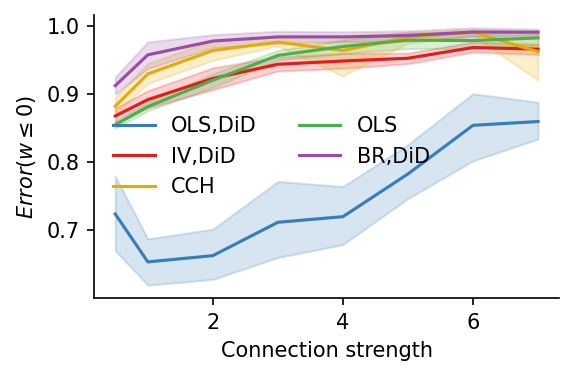

In [78]:
from utils import labels, colors
label = lambda x: ','.join([labels[l] for l in x.split('_')[2:]])
keys = ['error_beta_ols_did', 'error_beta_iv_did', 'error_naive_cch','error_beta_ols', 'error_beta_brew_did']
for target_weight, df in errors.items():
    d = defaultdict(list)
    ekey = '$Error(w < 0)$' if target_weight=='weight<0' else '$Error(w = 0)$' if target_weight=='weight==0' else '$Error(w \leq 0)$'
    for key in keys:
        d[ekey].extend(df[key].values.tolist())
        d['group'].extend([label(key)]*len(df))
        d['Connection strength'].extend(df['sigma'].values.tolist())
    plt.figure()
    sns.lineplot(
        data=d,
        x="Connection strength", y=ekey,
        hue="group",
        palette={label(key): colors[label(key).lower()] for key in keys}
    )
    sns.despine()
    plt.legend(frameon=False, ncol=2, loc='center left')
    savefig(f'sweep_16_comparison_connection_strength_{target_weight}')

In [21]:
from utils import violin_compare_all

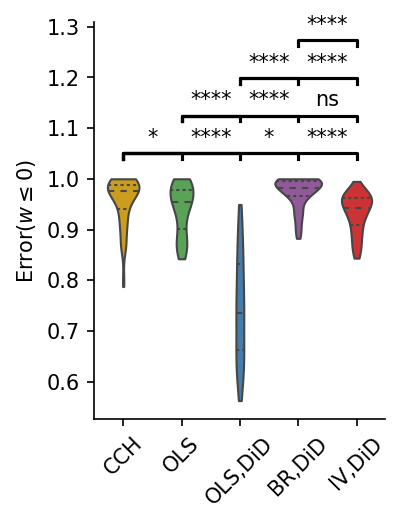

In [33]:
for target_weight in errors:
    violin_compare_all(
        ['error_naive_cch', 
         'error_beta_ols', 
         'error_beta_ols_did', 
         'error_beta_brew_did',
         'error_beta_iv_did'], 
        target_weight=target_weight, 
        errors=errors, save='sweep_16_comparison_summary')

# Compare error between OLS and IV

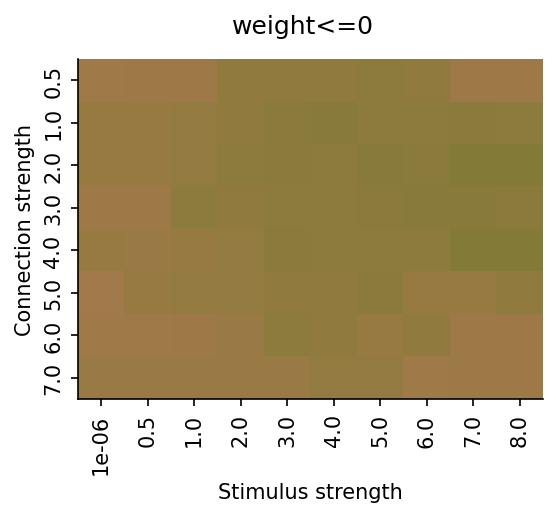

In [23]:
for target_weight, dff in errors.items():
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(4,3))
    sns.heatmap(
        df.pivot('sigma', 'stim_strength', 'error_beta_ols_did') - df.pivot('sigma', 'stim_strength', 'error_beta_iv_did'), 
#         annot=df.pivot('sigma', 'stim_strength', 'error_diff_ols_iv_did'), 
        cmap='cubehelix', vmin=-5, vmax=5, ax=ax, cbar=False,
        cbar_kws={'label': r'$\mathrm{error}(\beta_{DiD}) - \mathrm{error}(\beta_{IV,DiD})$'})
    ax.set_ylabel('Connection strength')
    ax.set_xlabel('Stimulus strength')
    plt.suptitle(target_weight)

    sns.despine()
    savefig(f'sweep_16_comparison_detailed_{target_weight}')

# Best classifier

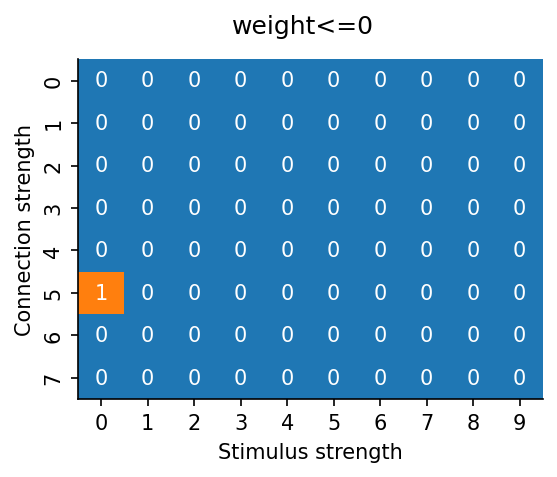

In [24]:
for k, dff in errors.items():
    fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(4,3))
    argmin_err = np.concatenate(
    [df.pivot('sigma', 'stim_strength', 'error_beta_ols_did').values[:,:,None], 
     df.pivot('sigma', 'stim_strength', 'error_beta_iv_did').values[:,:,None], 
     df.pivot('sigma', 'stim_strength', 'error_beta_brew_did').values[:,:,None]], axis=2).argmin(2)
    sns.heatmap(
        argmin_err, 
        annot=argmin_err, 
        cmap=['C0', 'C1', 'C2'], vmin=0, vmax=2, ax=ax, cbar=False)
    ax.set_ylabel('Connection strength')
    ax.set_xlabel('Stimulus strength')
    plt.suptitle(k + '\n')

sns.despine()

# Classificattion

In [25]:
samples = compute_all_samples(data_path)

  0%|          | 0/80 [00:00<?, ?it/s]

In [65]:
auroc = []
keys = ['beta_ols_did', 'beta_iv_did', 'beta_ols', 'naive_cch', 'beta_brew_did']
label = lambda x: ','.join([labels[l] for l in x.split('_')[1:]])
for index, df in samples.items():
#     df = rectify_keys(df, keys)
    ser = df.iloc[0]
    for key in keys:
        a = roc_auc_score(df, key, weight=-1)
        score = {
            'n_neurons': ser.n_neurons, 
            'stim_strength': ser.stim_strength, 
            'sigma': eval(ser.glorot_normal)['sigma'], 
            'group': label(key),
            'auroc': a
        }
        auroc.append(score)
auroc = pd.DataFrame(auroc)

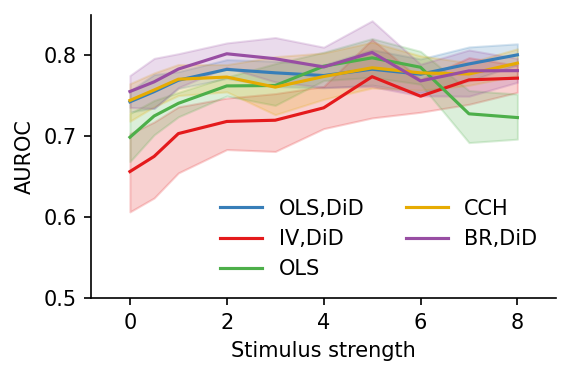

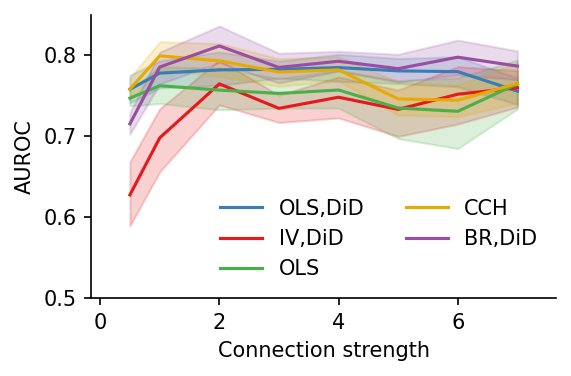

In [71]:
plt.figure()
sns.lineplot(
    data=auroc,#.sort_values('n_neurons'),
    x="stim_strength", y='auroc',
    hue="group",
    palette={label(key): colors[label(key).lower()] for key in keys}
)
plt.ylabel('AUROC')
plt.xlabel('Stimulus strength')
plt.ylim(0.5, 0.85)
plt.margins(0.1)
sns.despine()
plt.legend(frameon=False, ncol=2, loc=4)
savefig(f'sweep_16_auroc_stim_strength')

plt.figure()
sns.lineplot(
    data=auroc,#.sort_values('n_neurons'),
    x="sigma", y='auroc',
    hue="group",
    palette={label(key): colors[label(key).lower()] for key in keys}
)
plt.ylabel('AUROC')
plt.xlabel('Connection strength')
plt.ylim(0.5, 0.85)
plt.margins(0.1)
sns.despine()
plt.legend(frameon=False, ncol=2, loc=4)
savefig(f'sweep_16_auroc_conn_strength')

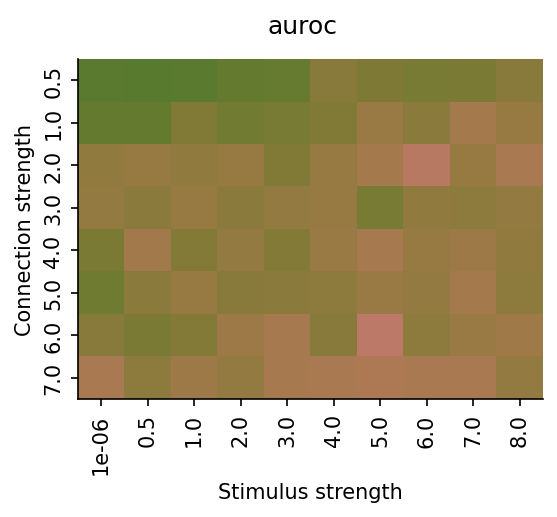

In [62]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(4,3))
mat = (auroc.query('group=="IV,DiD"').pivot('sigma', 'stim_strength', 'auroc') - 
       auroc.query('group=="OLS,DiD"').pivot('sigma', 'stim_strength', 'auroc'))

sns.heatmap(
    mat, cmap='cubehelix', vmin=-1, vmax=1, ax=ax, cbar=False)
ax.set_ylabel('Connection strength')
ax.set_xlabel('Stimulus strength')
plt.suptitle('auroc')
sns.despine()
savefig(f'sweep_16_auroc_difference')

# Regression

In [44]:
samples = compute_all_samples(data_path)

  0%|          | 0/80 [00:00<?, ?it/s]

In [45]:
concsamples = pd.concat([v for v in samples.values()])

In [55]:
concsamples = concsamples.assign(sigma=lambda x: [eval(v)['sigma'] for v in x.glorot_normal.values])

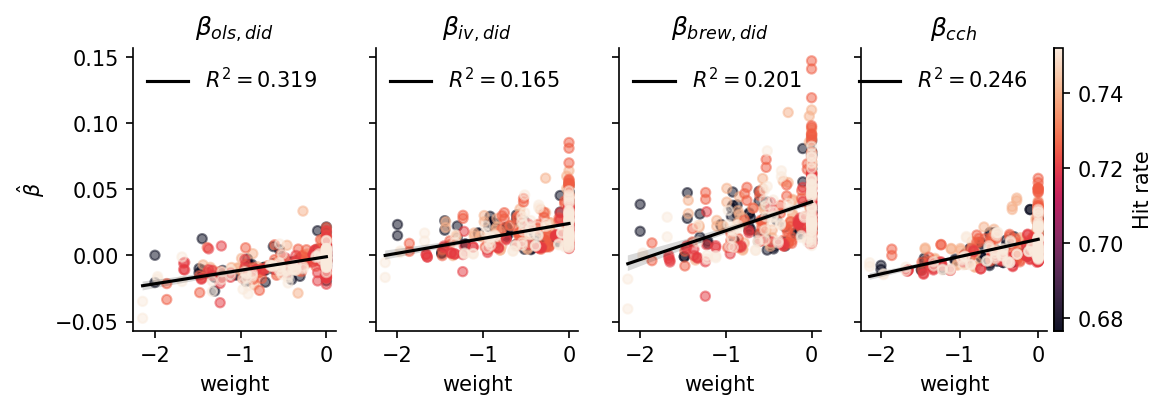

In [64]:
plot_regression(
    concsamples.query('weight<=0 and stim_strength==6 and sigma==6'), ['beta_ols_did','beta_iv_did', 'beta_brew_did', 'naive_cch'], 
    scatter_kws=dict(s=20, alpha=.5), clabel='Hit rate')
# plt.suptitle(f'N={n_neurons}')
# savefig(f'sweep_16_scatter_{n_neurons}')